# This script evaluates the Deep Matching and Validation Network (DMVN) on the paired CASIA dataset

Before you run this notebook, make sure
    
    - you have prepared the CASIA dataset as described in `data/README.md` 
    - you correctly set up your **Keras** enviroment with the Theano backend
    - standard libraries **NumPy**, **IPython**, and **cv2**(v2.4.9) are available



### Step 1. Load all required libs

In [1]:
%matplotlib inline
import os
import cv2
import sys
import numpy as np 
dmvn_root = os.getcwd()
dmvn_lib = os.path.join( dmvn_root, 'lib', 'dmvn' )
sys.path.insert( 0, dmvn_lib )
from core import create_DMVN_model
from utils import load_splicing_input_csv, get_unique_images_and_idxLUT, preprocess_images, filter_invalid_data, prepare_one_batch_input
from utils import visualize_debug_dualmask, evaluate_fscore, evaluate_auc
from matplotlib import pyplot
from sklearn.metrics import roc_curve
np.set_printoptions(3,suppress = True)

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


### Step 2. Set inputs and ouputs

In [3]:
# input paired CASIA dataset
input_splicing_csv = os.path.join( dmvn_root, 'data', 'local_paired_CASIA_files.csv' ) 
assert os.path.isfile( input_splicing_csv ), "ERROR: please prepare CASIA2 data as described in data/README.md"

# set output experiment directory
expt_dir = os.path.join( dmvn_root, 'expt', 'test_on_paired_casia' )
os.system( "mkdir -p %s" % expt_dir )
visualization_dir = os.path.join( expt_dir, 'visualization_results')
os.system( "mkdir -p %s" % visualization_dir)
output_res_csv = os.path.join( expt_dir, 'dmvn_on_paired_casia.csv' )

# set up decoding parameters
batch_size = 16 # batch size in DMVN process
visualization_level = -1 # if -1: suppress everything, 0: only print proba but no image, 1: only positive samples, 2: everything
vis_mask_thresh = 0.5 # mask threshold, if negative then use grayscale mask instead of binary


### Step 3. Prepare the paired CASIA2 data

It is known that OpenCV has problems to load some gif and tif images in CASIA2. To overcome this problem, one may first convert these problematic images manually. 

In [6]:
# load input pairs and groundtruth labels
splicing_img_pair_list, label_list = load_splicing_input_csv( input_splicing_csv )
# reduce image pairs to unique images
splicing_idx_pair_list, unique_image_list = get_unique_images_and_idxLUT( splicing_img_pair_list )
# load unique images and convert to tensors
sample_tensor_list = preprocess_images( unique_image_list, n_jobs = 8, verbose = 10 )
# filter invalid samples
valid_idx_pair_list, valid_image_pair_list = filter_invalid_data( sample_tensor_list, splicing_idx_pair_list, splicing_img_pair_list )


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    6.7s
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 222 tasks      | elapsed:   10.9s
[Paralle

INFO: meet #invalid_image_samples = 0


### Step 4. DMVN prediction over all samples

In [7]:
# load pretrained model
dmvn_model = create_DMVN_model( ( 3, 256, 256 ) )


////////////////////////////////////////////////////////////////////////////////////////////////////
INFO: create CNN Feature Extractor
////////////////////////////////////////////////////////////////////////////////////////////////////
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 256, 256)   0                                            
____________________________________________________________________________________________________
vgg16_cnn_featex-block1_conv1 (C (None, 64, 256, 256)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
vgg16_cnn_featex-block1_conv2 (C (None, 64, 256, 256)  36928       vgg16_cnn_featex-block1_conv1[0][
________________________________________________________

NameError: name 'model_weight' is not defined

In [15]:
# prediction over all samples
nb_samples = len( valid_idx_pair_list )
dmvn_scores = []
for start_idx in range( 0, nb_samples, batch_size ) :
    end_idx = min( nb_samples, start_idx + batch_size )
    X = prepare_one_batch_input( sample_tensor_list, valid_idx_pair_list[ start_idx:end_idx ] )
    pred_masks, pred_probs = dmvn_model.predict( X )
    mask_perc = ( pred_masks > .5 ).mean( axis = (2,3) )
    world_perc, probe_perc = mask_perc.T
    det_score = pred_probs[:,1]
    dmvn_scores.append( np.column_stack( [ probe_perc, world_perc, det_score ] ) )
    # visualize samples if necessary
    for this_donor, this_probe, this_masks, this_probs, this_file_pair in zip( X['world'], X['probe'], pred_masks, pred_probs, valid_image_pair_list[ start_idx:end_idx ] ) :
        this_probe_id, this_donor_id = [ os.path.basename( f ).split('.')[0] for f in this_file_pair ]
        this_output_file = os.path.join( visualization_dir, "S-%.4f=P-%s_x_D-%s.jpg" % ( this_probs[1], this_probe_id, this_donor_id ) )
        _ = visualize_debug_dualmask( this_donor, this_probe, this_masks, this_probs,
                                      output_file = this_output_file,
                                      th = vis_mask_thresh,
                                      visualization_level = visualization_level )
    # print stats
    print "INFO: done", end_idx, "samples out of", nb_samples


INFO: done 16 samples out of 8642
INFO: done 32 samples out of 8642
INFO: done 48 samples out of 8642
INFO: done 64 samples out of 8642
INFO: done 80 samples out of 8642
INFO: done 96 samples out of 8642
INFO: done 112 samples out of 8642
INFO: done 128 samples out of 8642
INFO: done 144 samples out of 8642
INFO: done 160 samples out of 8642
INFO: done 176 samples out of 8642
INFO: done 192 samples out of 8642
INFO: done 208 samples out of 8642
INFO: done 224 samples out of 8642
INFO: done 240 samples out of 8642
INFO: done 256 samples out of 8642
INFO: done 272 samples out of 8642
INFO: done 288 samples out of 8642
INFO: done 304 samples out of 8642
INFO: done 320 samples out of 8642
INFO: done 336 samples out of 8642
INFO: done 352 samples out of 8642
INFO: done 368 samples out of 8642
INFO: done 384 samples out of 8642
INFO: done 400 samples out of 8642
INFO: done 416 samples out of 8642
INFO: done 432 samples out of 8642
INFO: done 448 samples out of 8642
INFO: done 464 samples out

### Step 5. Save prediction to output csv

In [16]:
dmvn_scores = np.row_stack( dmvn_scores )
# save prediction results
output_lines = [ ",".join( [ "probe_file", "donor_file", "proba" ] ) ]
for this_image_pair, this_score in zip( valid_image_pair_list, dmvn_scores ) :
    probe_file, donor_file = this_image_pair
    donor_perc, probe_perc, proba = this_score
    this_line = [ probe_file, donor_file ] + [ "%.4f" % proba ]
    output_lines.append( ",".join( this_line ) )

with open( output_res_csv, 'w' ) as OUT :
    OUT.write( "\n".join( output_lines ) + "\n" )

print "INFO: successfully save all prediction scores into", output_res_csv

INFO: successfully save all prediction scores into /nas/medifor/yue_wu/release/Deep-Matching-Validation-Network/expt/test_on_paired_casia/dmvn_on_paired_casia.csv


### Step 6. Performance evalution

INFO: DMVN-loc on the paired CASIA dataset fscore = 0.81872909699
INFO: DMVN-det on the paired CASIA dataset fscore = 0.858191831115
INFO: DMVN-loc on the paired CASIA dataset auc = 0.902429489292
INFO: DMVN-det on the paired CASIA dataset auc = 0.925318259198


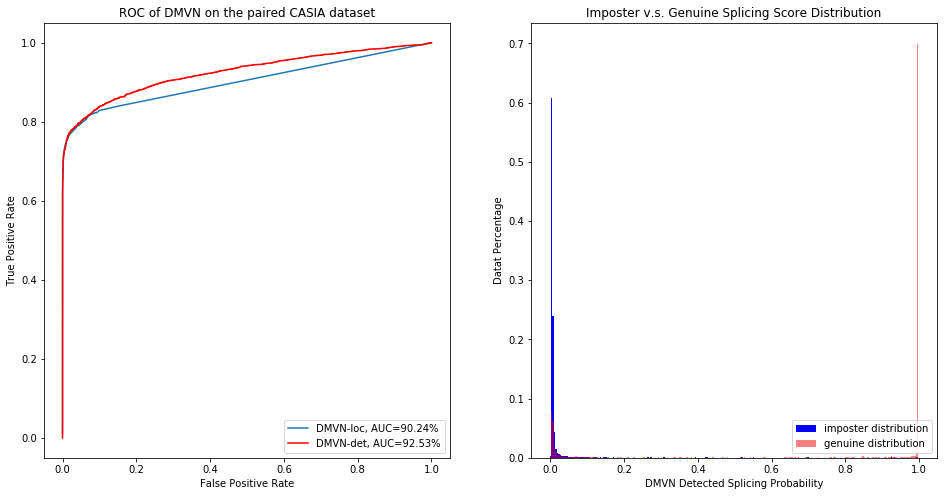

In [64]:
lut = dict( zip( splicing_img_pair_list, label_list  ) )
y_true = np.array( [ int( lut[ key ] ) for key in valid_image_pair_list ] )
y_pred_loc = dmvn_scores[:,[0,1]].mean( axis = -1 )
y_pred_det = dmvn_scores[:,2]
# evaluate using fscore
_ = evaluate_fscore( y_true, y_pred_loc > 0, 'DMVN-loc on the paired CASIA dataset')
_ = evaluate_fscore( y_true, y_pred_det > .5, 'DMVN-det on the paired CASIA dataset')
# evaluate using auc
auc0 = evaluate_auc( y_true, y_pred_loc, 'DMVN-loc on the paired CASIA dataset' )
auc1 = evaluate_auc( y_true, y_pred_det, 'DMVN-det on the paired CASIA dataset' )
# prepare ROC curve
fpr0, tpr0, _ = roc_curve ( y_true, y_pred_loc, 1 )
fpr1, tpr1, _ = roc_curve ( y_true, y_pred_det, 1 )
# prepare imposter v.s. genuine score distribution
pos_idx = np.nonzero( y_true == 1 )[0].tolist()
neg_idx = np.nonzero( y_true == 0 )[0].tolist()
hist_x = np.linspace( 0, 1, 257 )
imposter_cnt, _ = np.histogram( y_pred_det[ neg_idx ], hist_x )
imposter_prob = imposter_cnt.astype( float ) / np.sum( imposter_cnt )
genuine_cnt, _ = np.histogram( y_pred_det[ pos_idx ], hist_x )
genuine_prob = genuine_cnt.astype( float ) / np.sum( genuine_cnt )
# plot
pyplot.figure( figsize=(16,8) )
pyplot.subplot(121)
pyplot.plot( fpr0, tpr0 )
pyplot.plot( fpr1, tpr1, 'r' )
pyplot.legend( [ 'DMVN-loc, AUC=%.2f%%' % ( auc0 * 100 ), 'DMVN-det, AUC=%.2f%%' % (auc1 * 100) ], loc = 4 )
pyplot.xlabel( 'False Positive Rate' )
pyplot.ylabel( 'True Positive Rate' )
pyplot.title( 'ROC of DMVN on the paired CASIA dataset' )
pyplot.subplot(122)
pyplot.bar( hist_x[:-1], imposter_prob, alpha = 1, width = 1./256, color = 'b' )
pyplot.bar( hist_x[:-1], genuine_prob, alpha = .5, width = 1./256, color = 'r' )
pyplot.legend( [ 'imposter distribution', 'genuine distribution'], loc = 4 )
pyplot.xlabel( 'DMVN Detected Splicing Probability' )
pyplot.ylabel( 'Datat Percentage' )
pyplot.title( 'Imposter v.s. Genuine Splicing Score Distribution' )
pyplot.show()

